<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-02-05-regularized-gam-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 5. Generalized Additive Model with Lasso (GAMLASSO)

GAMLASSO stands for Generalized Additive Model with the Least Absolute Shrinkage and Selection Operator. It is a statistical technique that combines the flexibility of Generalized Additive Models (GAM) with the variable selection and regularization properties of LASSO (Least Absolute Shrinkage and Selection Operator). This approach is particularly useful for modeling complex, non-linear relationships while performing variable selection and regularization in high-dimensional settings.


## Overview

Generalized Additive Model with Lasso (GAMLASSO) is a statistical approach that combines the flexibility of Generalized Additive Models (GAMs) with the variable selection and regularization properties of LASSO (Least Absolute Shrinkage and Selection Operator).

### Generalized Additive Model (GAM)

A Generalized Additive Model (GAM) is a type of regression model where the relationship between the response variable $Y$ and the predictor variables $X_i$ is modeled as the sum of smooth functions of the predictor variables:

$$ g(\mathbb{E}[Y]) = \beta_0 + \sum_{j=1}^p f_j(X_j) $$

Here:
- $g(\cdot)$ is the link function.
- $\mathbb{E}[Y]$ is the expected value of the response variable $Y$.
- $\beta_0$ is the intercept.
- $f_j(X_j)$ are smooth functions (e.g., splines) of the predictor variables $X_j$.


### LASSO (Least Absolute Shrinkage and Selection Operator)

LASSO is a regression technique that adds a penalty to the absolute size of the regression coefficients. The LASSO objective function is:

$$ \min_{\beta} \left( \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{x}_i^T \beta)^2 + \lambda \sum_{j=1}^p |\beta_j| \right) $$

Here:
- $y_i$ is the response variable.
- $\mathbf{x}_i$ is the vector of predictor variables.
- $\beta_j$ are the regression coefficients.
- $\lambda$ is the regularization parameter.

### Combining GAM and LASSO (GAMLASSO)

GAMLASSO integrates the smooth functions of GAM with the LASSO penalty to perform variable selection and regularization within the GAM framework. The objective function for GAMLASSO can be written as:

$$ \min_{f_j} \left( \frac{1}{2n} \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p f_j(x_{ij}) \right)^2 + \lambda \sum_{j=1}^p \| f_j \|_1 \right) $$

Here:
- $x_{ij}$ are the predictor variables.
- $f_j(x_{ij})$ are the smooth functions of the predictor variables.
- $\lambda$ is the regularization parameter.
- $\| f_j \|_1$ is the LASSO penalty applied to the smooth functions, which can be expressed as the norm of the coefficients of the basis functions (e.g., splines) used to represent $f_j$.


### Interpretation

- **Smooth Functions**: The smooth functions $f_j(X_j)$ capture the non-linear relationships between the predictors and the response variable.
- **LASSO Penalty**: The LASSO penalty $\sum_{j=1}^p \| f_j \|_1$ encourages sparsity in the model by shrinking some of the smooth function coefficients to zero, effectively selecting a subset of important predictors.
- **Regularization Parameter**: The regularization parameter $\lambda$ controls the trade-off between the goodness of fit and the complexity of the model. A larger $\lambda$ leads to more regularization (i.e., more coefficients being shrunk to zero).


GAMLASSO is a powerful technique that leverages the strengths of both GAM and LASSO, making it suitable for modeling complex, non-linear relationships while performing variable selection and regularization. This approach is particularly useful in high-dimensional settings where interpretability and model sparsity are important.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314968 sha256=f2a92257d38485167495ba549d81c156762a0c16788dc38eba45865d32ef89f5
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Regularized GLM Regression Model from Scratch

To perform regularized regression (Ridge, Lasso, and Elastic Net) on synthetic data in R without using any libraries, we need to manually implement each regularization method in the GLM framework. Here’s how to proceed:

### Generate Synthetic Data

Let's create synthetic data with one continuous response variable $y$ and four predictors $x1, x2, x3, x4$.

In [3]:
%%R
# Generate data
set.seed(123)
n <- 100
x1 <- runif(n)
x2 <- runif(n)
x3 <- runif(n)
y <- 3 + 2 * sin(2 * pi * x1) + 1.5 * x2 + rnorm(n)
data <- data.frame(y, x1, x2, x3)
head(data)

         y        x1        x2        x3
1 6.632234 0.2875775 0.5999890 0.2387260
2 2.325924 0.7883051 0.3328235 0.9623589
3 5.147609 0.4089769 0.4886130 0.6013657
4 2.082125 0.8830174 0.9544738 0.5150297
5 2.874115 0.9404673 0.4829024 0.4025733
6 4.619824 0.0455565 0.8903502 0.8802465


### Spline basis function generator

Start by defining a function to generate spline basis functions for a given predictor variable `x` with a specified number of degrees of freedom `df`. The function will return a matrix of spline basis functions that can be used in the model. The basis functions include an intercept term, the original predictor, and the spline basis functions.


In [4]:
%%R
# Spline basis function generator
generate_spline_basis <- function(x, df = 10) {
  knots <- quantile(x, probs = seq(0, 1, length.out = df + 2))[-c(1, df + 2)]
  X <- outer(x, knots, '-')
  X <- X * (X > 0)
  return(cbind(1, x, X))
}



### Ridge penalty function

Ridge penalty function calculates the LASSO penalty for the regression coefficients. The intercept term is excluded from the penalty.    



In [5]:
%%R
# Ridge penalty function
penalty <- function(beta, lambda) {
  return(lambda * sum(abs(beta[-1]))) # Exclude intercept from penalty
}


### Generate spline basis matrices

Generate spline basis matrices for each predictor variable (`x1`, `x2`, `x3`) using the `generate_spline_basis` function. Combine all spline basis matrices into a single design matrix `X`.

In [6]:
%%R
# Coordinate descent algorithm
coordinate_descent <- function(X, y, lambda, tol = 1e-6, max_iter = 1000) {
  n <- nrow(X)
  p <- ncol(X)
  beta <- rep(0, p)
  for (iter in 1:max_iter) {
    beta_old <- beta
    for (j in 1:p) {
      r <- y - X %*% beta + X[, j] * beta[j]
      z <- sum(X[, j] * r) / n
      if (j == 1) {
        beta[j] <- z
      } else {
        beta[j] <- sign(z) * max(0, abs(z) - lambda)
      }
    }
    if (sum(abs(beta - beta_old)) < tol) break
  }
  return(beta)
}

### Generate spline basis matrices

Generate spline basis matrices for each predictor variable (`x1`, `x2`, `x3`) using the `generate_spline_basis` function. Combine all spline basis matrices into a single design matrix `X`.

In [7]:
%%R -w 600 -h 400

# Generate spline basis matrices
X1 <- generate_spline_basis(data$x1, df = 10)
X2 <- generate_spline_basis(data$x2, df = 10)
X3 <- generate_spline_basis(data$x3, df = 10)

# Combine all spline basis matrices
X <- cbind(X1, X2, X3)

### Fit the GAMLASSO model



In [9]:
%%R
# Fit the GAMLASSO model
lambda <- 0.1 # Regularization parameter
beta <- coordinate_descent(X, data$y, lambda)
beta

 [1]  4.09697011 -0.25699452 -0.22044171 -0.19675846 -0.16212538 -0.10906819
 [7] -0.06735472 -0.01571663  0.00000000  0.00000000  0.00000000  0.00000000
[13]  0.00000000  0.07618429  0.05630040  0.04117221  0.03221870  0.01473579
[19]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[25]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000
[31]  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000  0.00000000


### Make predictions

In [10]:
%%R
# Predict function
predict_gamlasso <- function(newdata, beta, df = 10) {
  X1_new <- generate_spline_basis(newdata$x1, df = df)
  X2_new <- generate_spline_basis(newdata$x2, df = df)
  X3_new <- generate_spline_basis(newdata$x3, df = df)
  X_new <- cbind(X1_new, X2_new, X3_new)
  return(X_new %*% beta)
}

# Make predictions
preds <- predict_gamlasso(data, beta)

### Evaluate Model Performance

To evaluate the models, calculate the Mean Squared Error (MSE) between the true response and predicted values.

In [11]:
%%R
calculate_metrics <- function(observed, predicted) {
  # Ensure inputs are numeric vectors
  observed <- as.numeric(observed)
  predicted <- as.numeric(predicted)

  # Compute metrics
  mse <- mean((observed - predicted)^2)
  rmse <- sqrt(mse)
  mae <- mean(abs(observed - predicted))
  medae <- median(abs(observed - predicted))
  r2 <- 1 - sum((observed - predicted)^2) / sum((observed - mean(observed))^2)

  # Return results as a named list
  metrics <- list(
    RMSE = rmse,
    MAE = mae,
    MSE = mse,
    MedAE = medae,
    R2 = r2
  )
  return(metrics)
}

In [12]:
%%R
calculate_metrics(preds, data$y)

$RMSE
[1] 1.726434

$MAE
[1] 1.424146

$MSE
[1] 2.980574

$MedAE
[1] 1.209919

$R2
[1] -40.43551



## GAMLASSO  Model in R

There are several R packages that can be used to fit Generalized Additive Models with Lasso (GAMLASSO) or similar models. Here are some of the most commonly used packages:

1. **`gamlss`**: This package is designed for fitting generalized additive models for location, scale, and shape. It supports various types of distributions and allows for penalized regression models.

2. **`plsmselect`**: This package is specifically designed for penalized variable selection in generalized additive models and supports various penalties, including LASSO.

3. **`grpreg`**: This package focuses on regression models with grouped covariates and supports group LASSO, which can be useful for GAMLASSO models.

Here is how you can install these packages:

```r
install.packages("gamlss")
install.packages("plsmselect")
install.packages("grpreg")
```

### Example Usage:

#### Using `gamlss`

```r
library(gamlss)
data <- data.frame(y = rnorm(100), x1 = runif(100), x2 = runif(100))
fit <- gamlss(y ~ pb(x1) + pb(x2), data = data, family = NO)
summary(fit)
```


#### Using `plsmselect`

```r
library(plsmselect)
data <- data.frame(y = rnorm(100), x1 = runif(100), x2 = runif(100))
fit <- gamlasso(y ~ s(x1) + s(x2), data = data, family = gaussian())
summary(fit)
```

#### Using `grpreg`

```r
library(grpreg)
data <- data.frame(y = rnorm(100), x1 = runif(100), x2 = runif(100))
X <- model.matrix(y ~ x1 + x2, data)[, -1]
group <- rep(1:2, each = 1)
fit <- grpreg(X, data$y, group = group, penalty = "grLasso")
summary(fit)
```


These are some of the packages and their basic usage for fitting GAMLASSO or similar models in R. Each package has its own strengths and can be chosen based on specific requirements and preferences.

### Install Rrequired R Packages

In [19]:
%%R
packages <- c('tidyverse',
     'plyr',
		 'ggpmisc',
		 'rstatix',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'plsmselect',
		 'gamlss',
		 'grpreg',
		 'glmnet',
		 'MASS',
		 'mlbench',
		 'AER'
		 )


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [20]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
 tidyverse       plyr    ggpmisc    rstatix  ggeffects  patchwork    Metrics 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
   ggpmisc plsmselect     gamlss     grpreg     glmnet       MASS    mlbench 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
       AER 
      TRUE 


### Load R Packages

In [21]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages


Successfully loaded packages:
 [1] "package:AER"         "package:survival"    "package:sandwich"   
 [4] "package:lmtest"      "package:zoo"         "package:car"        
 [7] "package:carData"     "package:mlbench"     "package:MASS"       
[10] "package:glmnet"      "package:Matrix"      "package:grpreg"     
[13] "package:gamlss"      "package:parallel"    "package:nlme"       
[16] "package:gamlss.dist" "package:gamlss.data" "package:splines"    
[19] "package:plsmselect"  "package:Metrics"     "package:patchwork"  
[22] "package:ggeffects"   "package:rstatix"     "package:ggpmisc"    
[25] "package:ggpp"        "package:plyr"        "package:lubridate"  
[28] "package:forcats"     "package:stringr"     "package:dplyr"      
[31] "package:purrr"       "package:readr"       "package:tidyr"      
[34] "package:tibble"      "package:ggplot2"     "package:tidyverse"  
[37] "package:tools"       "package:stats"       "package:graphics"   
[40] "package:grDevices"   "package:utils"     

### Gaussian GAMLASSO model

A Gaussian GAMLASSO model is a type of statistical model that combines the flexibility of Generalized Additive Models (GAM) with the regularization and variable selection capabilities of Lasso (Least Absolute Shrinkage and Selection Operator), specifically tailored for Gaussian (normal) distributed response variables.

A Gaussian GAMLASSO model is a type of statistical model that combines the flexibility of Generalized Additive Models (GAM) with the regularization and variable selection capabilities of Lasso (Least Absolute Shrinkage and Selection Operator), specifically tailored for Gaussian (normal) distributed response variables.

**Key Components**

1. **Generalized Additive Models (GAM)**:
   - GAMs allow for flexible modeling of relationships between a response variable and one or more predictor variables by using smooth functions (e.g., splines).
   - The model can capture non-linear relationships between the predictors and the response.

2. **Lasso (Least Absolute Shrinkage and Selection Operator)**:
   - Lasso is a regression technique that performs variable selection and regularization by adding a penalty equal to the absolute value of the magnitude of the coefficients.
   - This penalty can shrink some coefficients to zero, effectively selecting a subset of the predictors.

3. **Gaussian Distribution**:
   - The Gaussian (normal) distribution is used for the response variable, indicating that the residuals (errors) of the model are normally distributed.
   - This is suitable for modeling continuous response variables that follow a normal distribution.



The objective function for a Gaussian GAMLASSO model can be written as:
$$\min_{f_j} \left( \frac{1}{2n} \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^p f_j(x_{ij}) \right)^2 + \lambda \sum_{j=1}^p \| f_j \|_1 \right)$$

Here:

- $y_i$ is the response variable.
- $x_{ij}$ are the predictor variables.
- $f_j(x_{ij})$ are the smooth functions of the predictor variables.
- $\beta_0$ is the intercept term.
- $\lambda$ is the regularization parameter.
- $\| f_j \|_1$ is the Lasso penalty applied to the smooth functions.

**Interpretation**:

- **Smooth Functions**: The $f_j(x_{ij})$ terms allow for capturing complex, non-linear relationships between the predictors and the response.
- **Lasso Penalty**: The Lasso penalty $\sum_{j=1}^p \| f_j \|_1$ encourages sparsity by shrinking some of the smooth functions to zero, effectively selecting a subset of relevant predictors.
- **Regularization Parameter**: The parameter $\lambda$ controls the trade-off between fitting the data well and keeping the model simple (i.e., fewer non-zero coefficients).

#### Data

The Boston housing dataset is a classic dataset used in regression analysis. It contains information about various housing attributes in Boston, such as crime rate, property tax rate, pupil-teacher ratio, etc. The goal is to predict the median value of owner-occupied homes (`medv`) based on these attributes.

* `crim`: per capita crime rate by town.

* `zn`: proportion of residential land zoned for lots over 25,000 sq.ft.

* `indus`: proportion of non-retail business acres per town.

* `chas`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

* `nox`: nitrogen oxides concentration (parts per 10 million).

* `rm`" average number of rooms per dwelling.

* `age`: proportion of owner-occupied units built prior to 1940.

* `dis`: weighted mean of distances to five Boston employment centres.

* `rad`: index of accessibility to radial highways.

* `tax`: full-value property-tax rate per $10,000.

* `ptratio`: pupil-teacher ratio by town.

* `black`: 1000(Bk - 0.63)^2 where Bk is the proportion  by town

* `lstat`: lower status of the population (percent).

* *`medv`: median value of owner-occupied homes in $1000s

Source
Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.


We will use `read_csv()` function of **readr** package to import data as a **tidy** data.


In [22]:
%%R
# Load the Boston housing data
data(Boston, package = "MASS")
df<-Boston |>
  dplyr::select(medv,  crim, zn, indus, nox, rm, age,  dis,  rad,  tax, ptratio , black,  lstat,
         chas) |>
  glimpse()

Rows: 506
Columns: 14
$ medv    <dbl> 24.0, 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15…
$ crim    <dbl> 0.00632, 0.02731, 0.02729, 0.03237, 0.06905, 0.02985, 0.08829,…
$ zn      <dbl> 18.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 12.5, 12.5, 12.5, 12.5, 1…
$ indus   <dbl> 2.31, 7.07, 7.07, 2.18, 2.18, 2.18, 7.87, 7.87, 7.87, 7.87, 7.…
$ nox     <dbl> 0.538, 0.469, 0.469, 0.458, 0.458, 0.458, 0.524, 0.524, 0.524,…
$ rm      <dbl> 6.575, 6.421, 7.185, 6.998, 7.147, 6.430, 6.012, 6.172, 5.631,…
$ age     <dbl> 65.2, 78.9, 61.1, 45.8, 54.2, 58.7, 66.6, 96.1, 100.0, 85.9, 9…
$ dis     <dbl> 4.0900, 4.9671, 4.9671, 6.0622, 6.0622, 6.0622, 5.5605, 5.9505…
$ rad     <int> 1, 2, 2, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4,…
$ tax     <dbl> 296, 242, 242, 222, 222, 222, 311, 311, 311, 311, 311, 311, 31…
$ ptratio <dbl> 15.3, 17.8, 17.8, 18.7, 18.7, 18.7, 15.2, 15.2, 15.2, 15.2, 15…
$ black   <dbl> 396.90, 396.90, 392.83, 394.63, 396.90, 394.12, 395.60, 396.90…
$ lstat   <dbl> 4.

#### Split dats into training and testing sets

In [23]:
%%R
# Split the data into training and testing sets
# Set seed for reproducibility
set.seed(123)
# Define the proportion of data to be used for training
train_proportion <- 0.8
# Calculate the number of training samples
train_size <- floor(train_proportion * nrow(Boston))
# Generate a random sample of row indices for training data
train_indices <- sample(seq_len(nrow(Boston)), size = train_size)
# Split the data into training and testing sets
trainData <- Boston[train_indices, ]
testData <- Boston[-train_indices, ]
# Inspect the dimensions of the resulting datasets
cat("Training set dimensions: ", dim(trainData), "\n")
cat("Testing set dimensions: ", dim(testData), "\n")


Training set dimensions:  404 14 
Testing set dimensions:  102 14 


#### Data Processing

In [24]:
%%R
# Define the response and predictor variables
response_var <- "medv"

# 🛠 FIX: Ensure at least two variables in linear terms
linear_terms <- c("chas", "rm")  # Adding "rm" as a linear term to avoid single-column matrix issue
smooth_terms <- c("crim", "zn", "indus", "nox", "age", "dis", "rad", "tax", "ptratio", "black", "lstat")

# Check if all predictor variables exist
predictor_vars <- c(linear_terms, smooth_terms)
missing_vars <- setdiff(predictor_vars, names(trainData))
if (length(missing_vars) > 0) {
  stop(paste("Missing columns:", paste(missing_vars, collapse = ", ")))
}

# Ensure all predictors are numeric
trainData[predictor_vars] <- lapply(trainData[predictor_vars], function(x) as.numeric(as.character(x)))

# Convert predictor data to a matrix
predictors <- as.matrix(trainData[predictor_vars])

# Print matrix dimensions (should be more than one column)
print(dim(predictors))

# Ensure at least 2 predictor variables exist
if (ncol(predictors) < 2) {
  stop("Error: The predictor matrix must have at least 2 columns before fitting the model.")
}

[1] 404  13


####  Fit a GAMLASSO model on the training data

We will fit a GAMLASSO model using `gamlasso()` funtion of  the {plsmselect} package on the training data. The model will predict the median value of owner-occupied homes (`medv`) based on the other attributes in the dataset.  The formula specifies that the response variable `medv` is modeled as a function of smooth terms of the predictors. The degrees of freedom for each smoothing term are reduced by specifying `k = 5` to avoid the error related to excessive degrees of freedom. The variable `chas `is included as a linear term since it is a binary indicator variable.

`linear.penalty`: The penalty used on the linear predictors. A character string which can be "none" (default), "l1" or "l2". If "l1" is used then we use the gam and lasso loop. Otherwise only a gam model is fitted (with penalities on parametric terms if linear.penalty = "l2" ).

`smooth.penalty`: The penalty used on the smoothers. A character string which can be "l1" or "l2" (default). "l2" refers to the inherent second order penalty smoothers have for controlling their shape, so "none" is not an option. For "l1" basis is specified by bs='ts', else bs='tp' is used. (see gam for details on basis types)


In [25]:
%%R
gfit <- gamlasso(
      response = response_var,  # Keep as a string
      linear.terms = linear_terms,
      smooth.terms = smooth_terms,
      data = trainData,
      linear.penalty = "l1",
      smooth.penalty = "l1",
      num.knots = 5,
      family = "gaussian",
      seed = 1
)

Preliminary checks passed. 





In [42]:
%%R
# Print the summary of the model
summary(gfit)

$lasso
3 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept) .        
chas        2.8864801
rm          0.8568178

$gam

Family: gaussian 
Link function: identity 

Formula:
medv ~ s(crim, k = 5, bs = "ts") + s(zn, k = 5, bs = "ts") + 
    s(indus, k = 5, bs = "ts") + s(nox, k = 5, bs = "ts") + s(age, 
    k = 5, bs = "ts") + s(dis, k = 5, bs = "ts") + s(rad, k = 5, 
    bs = "ts") + s(tax, k = 5, bs = "ts") + s(ptratio, k = 5, 
    bs = "ts") + s(black, k = 5, bs = "ts") + s(lstat, k = 5, 
    bs = "ts")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  16.9542     0.1968   86.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df       F  p-value    
s(crim)    2.353e+00      4   7.560 2.56e-07 ***
s(zn)      3.728e+00      4   3.347 0.005453 ** 
s(indus)   3.802e-08      4   0.000 0.312298    
s(nox)     1.374e+00      4  

The Generalized Additive Model (GAM) fitted using the `gamlasso()` function shows that the response variable "medv" is significantly influenced by the predictor variables "chas" and "rm" with positive linear effects. Additionally, significant non-linear relationships were identified for "crim", "zn", "nox", "dis", "rad", "tax", "ptratio", "black", and "lstat", while "indus" was not significant. The model explains 81.5% of the variance in "medv" with an adjusted R-squared of 0.815 and a deviance explained of 80.4%, indicating a good fit to the data.

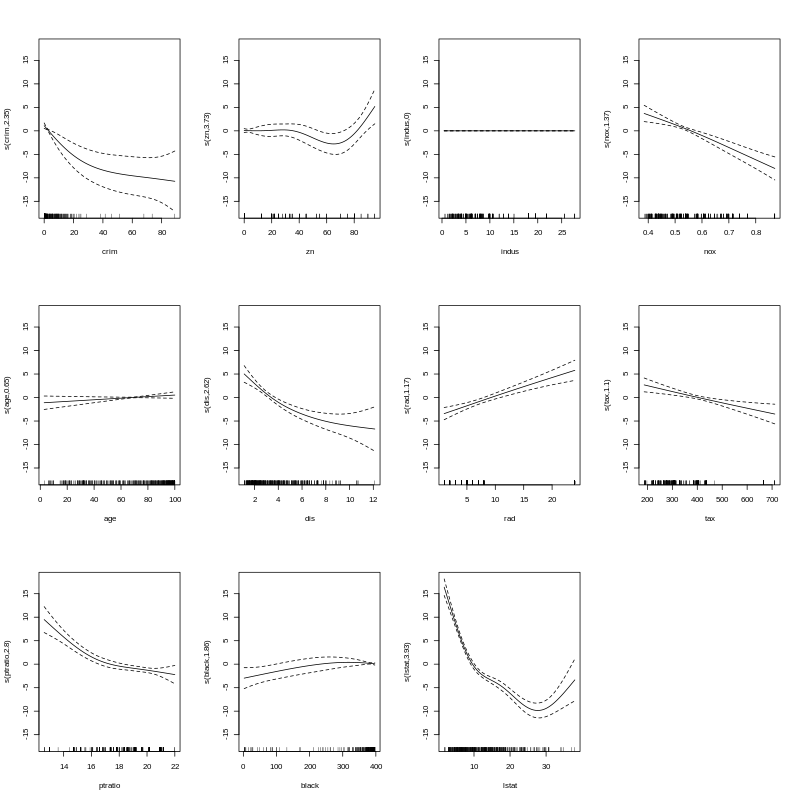

In [26]:
%%R -w 800 -h 800 -u px
# Plot the fitted smooth functions
plot(gfit$gam, pages=1)

#### Plot fitted versus observed values

In [27]:
%%R
trainData$pred.medv<-predict(gfit, newdata = trainData)

In [28]:
%%R
# Model performance metrics
calculate_metrics(trainData$medv, trainData$pred.medv)

$RMSE
[1] 3.843254

$MAE
[1] 2.686995

$MSE
[1] 14.7706

$MedAE
[1] 1.944855

$R2
[1] 0.8250476



`geom_smooth()` using formula = 'y ~ x'


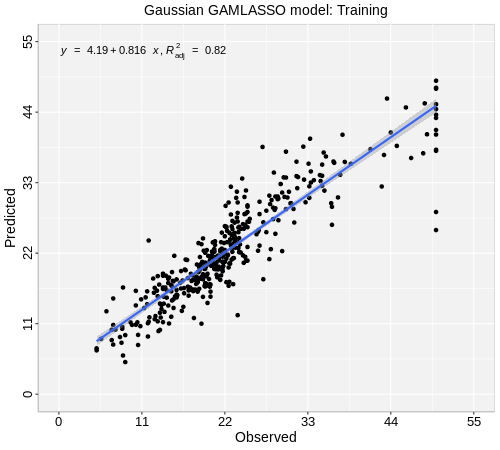

In [29]:
%%R -w 500 -h 450 -u px
library(ggpmisc)
formula<-y~x
# plot the predicted vs observed values
p1=ggplot(trainData, aes(medv, pred.medv)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Gaussian GAMLASSO model: Training") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,55), breaks=seq(0, 55, 11))+
  scale_y_continuous(limits=c(0,55), breaks=seq(0, 55, 11)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p1)

#### Prediction at Test Data

Now, we will test this model on our test dataset by calculating the model-predicted values for the test dataset and then computing the MAE, MSE, RMSE and R-square:

In [30]:
%%R
# Make predictions on the test data
testData$pred.medv<-predict(gfit, newdata = testData)

In [32]:
%%R
# Model performance metrics
calculate_metrics(testData$medv, testData$pred.medv)

$RMSE
[1] 4.465848

$MAE
[1] 3.27578

$MSE
[1] 19.9438

$MedAE
[1] 2.441494

$R2
[1] 0.7636513



#### 1:1 Plot of Predicted vs Observed values

We can plot observed and predicted values with fitted regression line with ggplot2

`geom_smooth()` using formula = 'y ~ x'


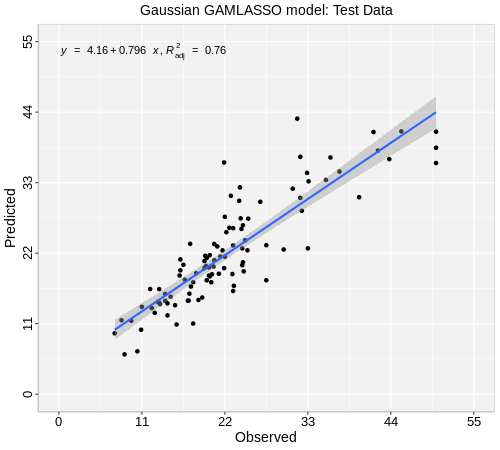

In [33]:
%%R -w 500 -h 450 -u px
formula<-y~x
# Lasso regression
# plot the predicted vs observed values
p2=ggplot(testData, aes(medv, pred.medv)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Gaussian GAMLASSO model: Test Data") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,55), breaks=seq(0, 55, 11))+
  scale_y_continuous(limits=c(0,55), breaks=seq(0, 55, 11)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))
print(p2)

### Binary Logistic GAMLASSO

The Binary Logistic GAMLASSO (Generalized Additive Model with Lasso) regression model is a statistical approach used for binary classification tasks. It combines the principles of Generalized Additive Models (GAMs) and Lasso regularization to model the relationship between a binary response variable and multiple predictor variables.

In the Binary Logistic GAMLASSO model, the logistic regression framework is combined with the flexibility of GAMs and the regularization properties of Lasso. This results in a model that can capture complex non-linear relationships while also performing variable selection to avoid overfitting.

The Binary Logistic GAMLASSO model can be formulated as follows:

$$ \log \left( \frac{P(Y=1)}{P(Y=0)} \right) = \beta_0 + f_1(X_1) + f_2(X_2) + \ldots + f_p(X_p) + \lambda \sum_{j=1}^{p} |\beta_j|
$$

where:

 - $P(Y=1)$ is the probability of the binary outcome being 1.

\- $\frac{P(Y=1)}{P(Y=0)}$ is the odds of the binary outcome.

\- $\beta_0$ is the intercept term.

\- $f_j(X_j)$ are the smooth functions of the predictor variables.

 - $\lambda$ is the regularization parameter.



#### Data

In this example, we will use the Pima Indians Diabetes dataset, which contains information about various health attributes of Pima Indian. The goal is to predict the presence or absence of diabetes based on these attributes. The response variable `diabetes` is binary (positive or negative). Dataset contains following columns:

* `pregnant` - 	Number of times pregnant
* `glucose` - 	Plasma glucose concentration (glucose tolerance test)
* `pressure` - 	Diastolic blood pressure (mm Hg)
* `triceps` - 	Triceps skin fold thickness (mm)
* `insulin` - 	2-Hour serum insulin (mu U/ml)
* `mass` - 	Body mass index (weight in kg/(height in m)\^2)
* `pedigree` - 	Diabetes pedigree function
* `age` - 	Age (years)
* `diabetes` - 	Class variable (0 or 1)

In [34]:
%%R
# Load the Pima Indians Diabetes dataset
data("PimaIndiansDiabetes")
data <- PimaIndiansDiabetes
glimpse(data)

Rows: 768
Columns: 9
$ pregnant <dbl> 6, 1, 8, 1, 0, 5, 3, 10, 2, 8, 4, 10, 10, 1, 5, 7, 0, 7, 1, 1…
$ glucose  <dbl> 148, 85, 183, 89, 137, 116, 78, 115, 197, 125, 110, 168, 139,…
$ pressure <dbl> 72, 66, 64, 66, 40, 74, 50, 0, 70, 96, 92, 74, 80, 60, 72, 0,…
$ triceps  <dbl> 35, 29, 0, 23, 35, 0, 32, 0, 45, 0, 0, 0, 0, 23, 19, 0, 47, 0…
$ insulin  <dbl> 0, 0, 0, 94, 168, 0, 88, 0, 543, 0, 0, 0, 0, 846, 175, 0, 230…
$ mass     <dbl> 33.6, 26.6, 23.3, 28.1, 43.1, 25.6, 31.0, 35.3, 30.5, 0.0, 37…
$ pedigree <dbl> 0.627, 0.351, 0.672, 0.167, 2.288, 0.201, 0.248, 0.134, 0.158…
$ age      <dbl> 50, 31, 32, 21, 33, 30, 26, 29, 53, 54, 30, 34, 57, 59, 51, 3…
$ diabetes <fct> pos, neg, pos, neg, pos, neg, pos, neg, pos, pos, neg, pos, n…


#### Split data into training and testing sets

In [35]:
%%R
# Convert the response variable to numeric binary format (0 and 1)
data$diabetes <- ifelse(data$diabetes == "pos", 1, 0)

# Set seed for reproducibility
set.seed(123)

# Define the proportion of data to be used for training
train_proportion <- 0.8

# Calculate the number of training samples
train_size <- floor(train_proportion * nrow(data))

# Generate a random sample of row indices for training data
train_indices <- sample(seq_len(nrow(data)), size = train_size)

# Split the data into training and testing sets
trainData <- data[train_indices, ]
testData <- data[-train_indices, ]
# Inspect the dimensions of the resulting datasets
cat("Training set dimensions: ", dim(trainData), "\n")
cat("Testing set dimensions: ", dim(testData), "\n")


Training set dimensions:  614 9 
Testing set dimensions:  154 9 


####  Define the response and predictor variables


In [36]:
%%R
# Define the response and predictor variables
response_var <- "diabetes"
linear_terms <- c("age", "pregnant")  # Linear terms
smooth_terms <- c("glucose", "pressure", "triceps", "insulin", "mass", "pedigree")  # Smooth terms

#### Fit a Binary Logistic GAMLASSO model on the training data

In [37]:
%%R
# Fit a Binary Logistic GAMLASSO model using plsmselect on the training data
bfit <- gamlasso(response = response_var,
                 linear.terms = linear_terms,
                 smooth.terms = smooth_terms,
                 data = trainData,
                 linear.penalty = "l1",
                 smooth.penalty = "l1",
                 num.knots = 5,
                 family = "binomial",
                 seed = 1)

Preliminary checks passed. 





In [38]:
%%R
# Print the summary of the model
summary(bfit)

$lasso
3 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) .         
age         0.01358471
pregnant    0.10610974

$gam

Family: binomial 
Link function: logit 

Formula:
diabetes ~ s(glucose, k = 5, bs = "ts") + s(pressure, k = 5, 
    bs = "ts") + s(triceps, k = 5, bs = "ts") + s(insulin, k = 5, 
    bs = "ts") + s(mass, k = 5, bs = "ts") + s(pedigree, k = 5, 
    bs = "ts")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.7925     0.1194  -15.01   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df Chi.sq p-value    
s(glucose)  3.5908602      4 86.597  <2e-16 ***
s(pressure) 0.8378293      4  4.460  0.0194 *  
s(triceps)  0.0005973      4  0.000  0.3592    
s(insulin)  0.5465537      4  1.183  0.1404    
s(mass)     3.8561442      4 36.681  <2e-16 ***
s(pedigree) 1.7605852      4  7.695  0.0101 *  
---
Signif. code

The Generalized Additive Model (GAM) fitted using the gamlasso function reveals that the likelihood of diabetes is significantly influenced by the predictor variables "age" and "pregnant" with positive linear effects. Additionally, significant non-linear relationships were found for "glucose", "pressure", "mass", and "pedigree", while "triceps" and "insulin" were not significant. The model explains 34.4% of the variance in diabetes probability with an adjusted R-squared of 0.344 and a deviance explained of 28%, indicating a moderate fit to the data.

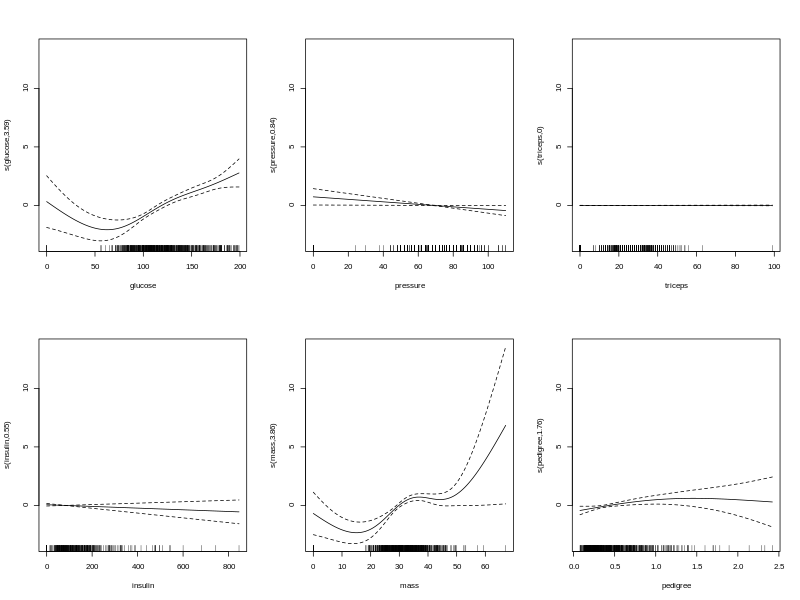

In [39]:
%%R -w 800 -h 600 -u px
# Plot the fitted smooth functions
plot(bfit$gam, pages=1)

#### Make predictions on the test data

In [40]:
%%R
# Make predictions on the test data
preds <- predict(bfit, newdata = testData, type = "response")
# Convert predictions to binary outcomes
preds_binary <- ifelse(preds > 0.5, 1, 0)

In [41]:
%%R
# Evaluate the model performance
accuracy <- mean(preds_binary == testData$diabetes)
confusion_matrix <- table(Predicted = preds_binary, Actual = testData$diabetes)

# Print the evaluation results
print(paste("Accuracy:", accuracy))
print("Confusion Matrix:")
print(confusion_matrix)

[1] "Accuracy: 0.74025974025974"
[1] "Confusion Matrix:"
         Actual
Predicted  0  1
        0 85 23
        1 17 29


### Poisson GAMLASSO Model

The Poisson GAMLASSO (Generalized Additive Model with Lasso) model is a statistical approach used for count data where the response variable follows a Poisson distribution. It combines the principles of Generalized Additive Models (GAMs) and Lasso regularization to model the relationship between the response variable and multiple predictor variables.

The Poisson GAMLASSO model can be formulated as follows:

$$ \log(\lambda) = \beta_0 + f_1(X_1) + f_2(X_2) + \ldots + f_p(X_p) + \lambda \sum_{j=1}^{p} |\beta_j| $$

where:

- $\lambda$ is the expected count.
- $\beta_0$ is the intercept.
- $f_i(X_i)$ are the smooth functions of the predictor variables.
- $\lambda$ is the regularization parameter.


#### Data

Data used in this example is the `Affairs` dataset from the AER package. The dataset contains information about extramarital affairs, including the number of affairs, age, years married, religiousness, rating of marriage, education, and occupation of individuals. The goal is to predict the number of affairs based on these attributes.

- `affairs`: number of affairs.
- `gender`:
- `age`: age of the individual.
- `yearsmarried`: number of years married.
- `children`: number of children.
- `religiousness`: religiousness rating.
- `education`: education level.
- `occupation`: occupation level.
- `rating`: rating of marriage.

In [43]:
%%R
# Load the Affairs dataset
data("Affairs", package = "AER")
data <- Affairs
# Inspect the dataset
head(data)

   affairs gender age yearsmarried children religiousness education occupation
4        0   male  37        10.00       no             3        18          7
5        0 female  27         4.00       no             4        14          6
11       0 female  32        15.00      yes             1        12          1
16       0   male  57        15.00      yes             5        18          6
23       0   male  22         0.75       no             2        17          6
29       0 female  32         1.50       no             2        17          5
   rating
4       4
5       4
11      4
16      5
23      3
29      5


#### Split data into training and testing sets

In [44]:
%%R
# Set seed for reproducibility
set.seed(123)

# Define the proportion of data to be used for training
train_proportion <- 0.8

# Calculate the number of training samples
train_size <- floor(train_proportion * nrow(data))

# Generate a random sample of row indices for training data
train_indices <- sample(seq_len(nrow(data)), size = train_size)

# Split the data into training and testing sets
trainData <- data[train_indices, ]
testData <- data[-train_indices, ]

#### Define the response and predictor variables

In [45]:
%%R
# Define the response and predictor variables
response_var <- "affairs"
linear_terms <- c("age", "yearsmarried", "religiousness", "rating")  # Linear terms
smooth_terms <- c("education", "occupation")  # Smooth terms with enough unique values

#### Fit a Poisson GAMLASSO model on the training data

In [47]:
%%R
# Fit a Poisson GAMLASSO model using plsmselect on the training data
pfit <- gamlasso(response = response_var,
                 linear.terms = linear_terms,
                 smooth.terms = smooth_terms,
                 data = trainData,
                 linear.penalty = "l1",
                 smooth.penalty = "l1",
                 num.knots = 5,
                 family = "poisson",
                 seed = 1)

Preliminary checks passed. 





In [48]:
%%R
# Print the summary of the model
summary(pfit)

$lasso
5 x 1 sparse Matrix of class "dgCMatrix"
                        s1
(Intercept)    .          
age           -0.009979784
yearsmarried   0.080983503
religiousness -0.349903533
rating        -0.323334349

$gam

Family: poisson 
Link function: log 

Formula:
affairs ~ s(education, k = 5, bs = "ts") + s(occupation, k = 5, 
    bs = "ts")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.10242    0.04088   51.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df Chi.sq p-value    
s(education)  3.9189      4 30.095 2.2e-06 ***
s(occupation) 0.6572      4  1.861  0.0903 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.125   Deviance explained = 2.05%
UBRE = 2.8796  Scale est. = 1         n = 480



The Generalized Additive Model (GAM) fitted using the `gamlasso()` function reveals insights into the factors influencing the number of affairs. The Lasso regularization identified significant linear effects for "age" (negative), "yearsmarried" (positive), "religiousness" (negative), and "rating" (negative). The intercept term is highly significant with an estimate of 2.10242 (p < 2e-16).

The GAM component shows significant non-linear relationships for "education" (p = 2.2e-06) and a marginally significant effect for "occupation" (p = 0.0903). The model explains 12.5% of the variance in the number of affairs, with an adjusted R-squared of 0.125 and a deviance explained of 2.05%. These results indicate that while the model captures some of the variation in the response variable, there may be other unmeasured factors influencing the number of affairs.

#### Prediction on test Data

In [ ]:
%%R
# Make predictions on the test data
testData$preds <- predict(pfit, newdata = testData, type = "response")
# Model performance metrics
calculate_metrics(testData$affairs, testData$preds)

## References

1. [The plsmselect package](https://cran.r-project.org/web/packages/plsmselect/vignettes/plsmselect.html)

2.  [gamsel](https://cran.r-project.org/web/packages/gamsel/gamsel.pdf )

3. [Regularization Paths for Regression Models with Grouped Covariates](https://pbreheny.github.io/grpreg/)


